In [2]:
import joblib
data = joblib.load('processed_data/model2_sequences_labels.pkl')
print(data['sequences'].shape)  # Vai mostrar (n_samples, n_timesteps, n_features)

(11006, 90, 2)


In [5]:
# Célula 1: Configuração e Importações

# Importação de bibliotecas essenciais
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Importações para TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Importações para Machine Learning (avaliação)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc #
from joblib import dump, load #

# Configurações de exibição do Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Desativar avisos
import warnings
warnings.filterwarnings('ignore')

print("Bibliotecas importadas com sucesso.")

# Definir caminho para os dados pré-processados
DATA_DIR = 'processed_data' #

# Nome do arquivo onde as sequências e rótulos foram salvos
SEQUENCES_FILE = 'model2_sequences_labels.pkl' # Adaptado do (era model2_sequences_labels.pkl)

Bibliotecas importadas com sucesso.


In [7]:
# Célula 1: Configuração e Importações (Sem alterações aqui, apenas para contexto)
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from joblib import dump, load

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings('ignore')

print("Bibliotecas importadas com sucesso.")

# --- Diretórios e Nomes de Arquivo ---
# Definir o diretório onde todos os dados processados e modelos serão salvos
DATA_DIR = 'processed_data'
# Garantir que o diretório 'processed_data' exista
os.makedirs(DATA_DIR, exist_ok=True)

# Nome do arquivo onde as sequências e rótulos brutos foram salvos inicialmente
SEQUENCES_FILE = 'model2_sequences_labels.pkl'

# Nomes dos arquivos para salvar os dados de teste (X e Y) após o escalonamento
# Esses arquivos serão usados pelo script de teste do ensemble
TEST_DATA_FILE_X = 'X_test_scaled.npy' # Renomeado para indicar que é escalonado
TEST_DATA_FILE_Y = 'y_test_labels.npy'

# Célula 2: Carregamento, Pré-processamento e Divisão dos Dados

print("Carregando dados de sequências pré-processados para o Modelo LSTM...")

try:
    # Carregar o dicionário contendo 'sequences' e 'labels'
    # O caminho completo para o arquivo de sequências brutas
    full_sequences_path = os.path.join(DATA_DIR, SEQUENCES_FILE)
    loaded_data = load(full_sequences_path)

    X = loaded_data['sequences']
    y = loaded_data['labels']

    print(f"Dados carregados de: {full_sequences_path}")
    print(f"Formato das sequências (X): {X.shape}")
    print(f"Formato dos rótulos (y): {y.shape}")

    # Exibir a distribuição dos rótulos
    unique_labels, counts = np.unique(y, return_counts=True)
    label_distribution = dict(zip(unique_labels, counts))
    print(f"Distribuição dos rótulos: {label_distribution}")
    if 1 in unique_labels and len(counts) > 1:
        print(f"Porcentagem da classe '1': {counts[1] / np.sum(counts):.2%}")
    elif 0 in unique_labels and len(counts) > 0 :
        print(f"Porcentagem da classe '0': {counts[0] / np.sum(counts):.2%}")
    else:
        print("Não foi possível calcular a porcentagem de uma das classes.")


except FileNotFoundError:
    print(f"Erro: Arquivo '{full_sequences_path}' não encontrado.")
    print("Por favor, certifique-se de que o notebook de preparação de dados foi executado corretamente e salvou o arquivo.")
    #exit() # Descomente para sair se o arquivo não for encontrado
except Exception as e:
    print(f"Ocorreu um erro ao carregar ou processar os dados: {e}")
    #exit() # Descomente para sair em caso de erro

print("\nDividindo o dataset em conjuntos de treino, validação e teste...")

# Divisão estratificada para manter a proporção das classes
# 1. Divisão inicial: 80% treino + validação, 20% teste
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Divisão do conjunto de treino+validação: 80% treino, 20% validação
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

print(f"Tamanho do conjunto de Treino: X={X_train.shape}, y={y_train.shape}")
print(f"Tamanho do conjunto de Validação: X={X_val.shape}, y={y_val.shape}")
print(f"Tamanho do conjunto de Teste: X={X_test.shape}, y={y_test.shape}")

# Padronização das características
n_samples, n_timesteps, n_features = X_train.shape

# Achatar para (num_samples * timesteps, num_features) para o Scaler
X_train_reshaped = X_train.reshape(-1, n_features)
X_val_reshaped = X_val.reshape(-1, n_features)
X_test_reshaped = X_test.reshape(-1, n_features)

print("\nPadronizando as características (StandardScaler)...")
scaler = StandardScaler()

# Ajustar o scaler APENAS no conjunto de treino reshaped
X_train_scaled_reshaped = scaler.fit_transform(X_train_reshaped)

# Aplicar o scaler nos conjuntos de validação e teste reshaped
X_val_scaled_reshaped = scaler.transform(X_val_reshaped)
X_test_scaled_reshaped = scaler.transform(X_test_reshaped)

# Reformatar de volta para (num_samples, timesteps, num_features)
X_train_scaled = X_train_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)
X_val_scaled = X_val_scaled_reshaped.reshape(X_val.shape[0], n_timesteps, n_features)
X_test_scaled = X_test_scaled_reshaped.reshape(X_test.shape[0], n_timesteps, n_features)

print("Padronização concluída.")
print("Dados prontos para o treinamento do Modelo LSTM.")

# --- Salvar os Dados de Teste Escalados ---
# Esses arquivos serão usados pelo script de avaliação do ensemble
full_test_X_path = os.path.join(DATA_DIR, TEST_DATA_FILE_X)
full_test_Y_path = os.path.join(DATA_DIR, TEST_DATA_FILE_Y)

np.save(full_test_X_path, X_test_scaled)
np.save(full_test_Y_path, y_test)
print(f"\nDados de teste escalonados salvos em '{full_test_X_path}' e '{full_test_Y_path}'.")

Bibliotecas importadas com sucesso.
Carregando dados de sequências pré-processados para o Modelo LSTM...
Dados carregados de: processed_data/model2_sequences_labels.pkl
Formato das sequências (X): (11006, 90, 2)
Formato dos rótulos (y): (11006,)
Distribuição dos rótulos: {0: 6889, 1: 4117}
Porcentagem da classe '1': 37.41%

Dividindo o dataset em conjuntos de treino, validação e teste...
Tamanho do conjunto de Treino: X=(7043, 90, 2), y=(7043,)
Tamanho do conjunto de Validação: X=(1761, 90, 2), y=(1761,)
Tamanho do conjunto de Teste: X=(2202, 90, 2), y=(2202,)

Padronizando as características (StandardScaler)...
Padronização concluída.
Dados prontos para o treinamento do Modelo LSTM.

Dados de teste escalonados salvos em 'processed_data/X_test_scaled.npy' e 'processed_data/y_test_labels.npy'.


--- Implementando e Treinando o Modelo CNN-LSTM ---


Model: "CNN_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 90, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_layer (Conv1D)           │ (None, 90, 64)         │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_conv                  │ (None, 90, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1d_layer (MaxPooling1D)  │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv (Dropout)          │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,793 (132.00 KB)

 Trainable params: 33,665 (131.50 KB)

 Non-trainable params: 128 (512.00 B)


Pesos de Classe Calculados: {0: 0.7987071898389657, 1: 1.336940015186029}

Iniciando treinamento do Modelo CNN-LSTM...
Epoch 1/100


I0000 00:00:1747964906.206868  357347 cuda_dnn.cc:529] Loaded cuDNN version 90501


221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6552 - loss: 0.6129
Epoch 1: val_accuracy improved from -inf to 0.72232, saving model to processed_data/best_model_cnn_lstm.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.6553 - loss: 0.6128 - val_accuracy: 0.7223 - val_loss: 0.5670
Epoch 2/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7194 - loss: 0.5575
Epoch 2: val_accuracy improved from 0.72232 to 0.73822, saving model to processed_data/best_model_cnn_lstm.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7194 - loss: 0.5575 - val_accuracy: 0.7382 - val_loss: 0.5120
Epoch 3/100
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7149 - loss: 0.5406
Epoch 3: val_accuracy improved from 0.73822 to 0.75355, saving model to processed_data/best_model_cnn_lstm.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7149 - loss: 0.5406 - val_accuracy: 0.7535 - val_loss: 0.5153
Epoch 4/100
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - a

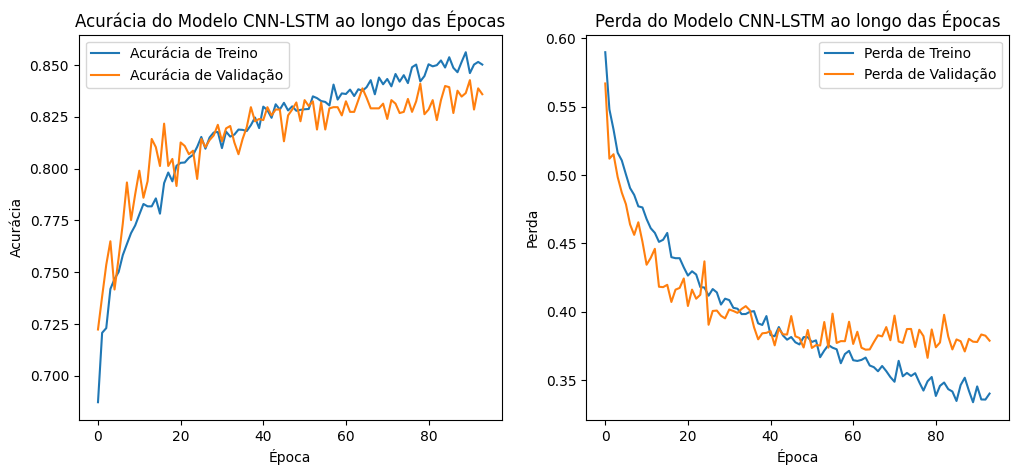

Melhor modelo CNN-LSTM carregado de: processed_data/best_model_cnn_lstm.keras

Treinamento do Modelo CNN-LSTM finalizado. Próximo passo: Avaliação do Modelo.


In [8]:
# Célula 3: Implementação e Treinamento do Modelo CNN-LSTM

print("--- Implementando e Treinando o Modelo CNN-LSTM ---")

# --- Parâmetros do Modelo ---
# CNN
NUM_FILTERS = 64         # Número de filtros na camada Conv1D
KERNEL_SIZE = 3          # Tamanho do kernel na camada Conv1D
POOL_SIZE = 2            # Tamanho da janela de pooling (se usar MaxPooling)

# LSTM
LSTM_UNITS = 64          # Número de unidades na camada LSTM
DROPOUT_RATE = 0.4       # Taxa de dropout para regularização (CNN e LSTM)
LEARNING_RATE = 0.001    # Taxa de aprendizado do otimizador
RECURRENT_DROPOUT_RATE = 0.2 # Taxa de dropout para conexões recorrentes LSTM

# --- Definição da Arquitetura CNN-LSTM ---
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
inputs = keras.Input(shape=input_shape)

# Camadas CNN
# Camada Conv1D para extrair características locais das sequências
x = layers.Conv1D(filters=NUM_FILTERS,
                  kernel_size=KERNEL_SIZE,
                  activation='relu',
                  padding='same', # 'causal' ou 'same' são comuns para sequências
                  name='conv1d_layer')(inputs)
x = layers.BatchNormalization(name='batchnorm_conv')(x) # Opcional, mas pode ajudar
x = layers.MaxPooling1D(pool_size=POOL_SIZE, name='maxpool1d_layer')(x) # Opcional
x = layers.Dropout(DROPOUT_RATE, name='dropout_conv')(x)

# Você pode adicionar mais camadas Conv1D/MaxPooling1D se desejar
# x = layers.Conv1D(filters=NUM_FILTERS*2, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv1d_layer_2')(x)
# x = layers.MaxPooling1D(pool_size=POOL_SIZE, name='maxpool1d_layer_2')(x)
# x = layers.Dropout(DROPOUT_RATE, name='dropout_conv_2')(x)

# Camada LSTM para processar as sequências de características extraídas pela CNN
# A saída da CNN (após MaxPooling) será a entrada para a LSTM
x = layers.LSTM(LSTM_UNITS,
                dropout=DROPOUT_RATE,
                recurrent_dropout=RECURRENT_DROPOUT_RATE,
                return_sequences=False, # False se for a última camada recorrente antes do Dense
                name='lstm_layer')(x)

# Opcional: Camada densa intermediária
# x = layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
# x = layers.Dropout(0.5)(x)

# Camada de saída
outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)

model_cnn_lstm = keras.Model(inputs=inputs, outputs=outputs, name='CNN_LSTM_Model')

# --- Compilação do Modelo ---
model_cnn_lstm.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model_cnn_lstm.summary()

# --- Callbacks para Treinamento ---
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

MODEL_SAVE_PATH_CNN_LSTM = os.path.join(DATA_DIR, 'best_model_cnn_lstm.keras')

model_checkpoint = ModelCheckpoint(
    MODEL_SAVE_PATH_CNN_LSTM,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Cálculo de pesos para lidar com desbalanceamento de classes (se houver)
class_weights = {}
unique_labels_train, counts_train = np.unique(y_train, return_counts=True)
total_samples_train = len(y_train)

if len(counts_train) == 2: # Certifica-se de que ambas as classes estão presentes
    class_weights[0] = total_samples_train / (2.0 * counts_train[0])
    class_weights[1] = total_samples_train / (2.0 * counts_train[1])
    print(f"\nPesos de Classe Calculados: {class_weights}")
else:
    print("\nNão foi possível calcular os pesos de classe (uma ou ambas as classes ausentes no treino). Usando pesos padrão.")
    class_weights = None


print("\nIniciando treinamento do Modelo CNN-LSTM...")

# --- Treinamento do Modelo ---
history_cnn_lstm = model_cnn_lstm.fit(
    X_train_scaled, y_train,
    epochs=100, # Pode precisar de ajuste
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weights,
    verbose=1
)

print("\nTreinamento do CNN-LSTM concluído.")

# --- Plotar histórico de treinamento ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn_lstm.history['accuracy'], label='Acurácia de Treino')
plt.plot(history_cnn_lstm.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia do Modelo CNN-LSTM ao longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_lstm.history['loss'], label='Perda de Treino')
plt.plot(history_cnn_lstm.history['val_loss'], label='Perda de Validação')
plt.title('Perda do Modelo CNN-LSTM ao longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.show()

# Carregar os melhores pesos salvos pelo ModelCheckpoint
try:
    model_cnn_lstm = keras.models.load_model(MODEL_SAVE_PATH_CNN_LSTM)
    print(f"Melhor modelo CNN-LSTM carregado de: {MODEL_SAVE_PATH_CNN_LSTM}")
except Exception as e:
    print(f"Não foi possível carregar o melhor modelo CNN-LSTM: {e}. Usando o modelo final do treinamento.")

print("\nTreinamento do Modelo CNN-LSTM finalizado. Próximo passo: Avaliação do Modelo.")

--- Avaliando o Modelo CNN-LSTM no Conjunto de Teste ---

Fazendo previsões no conjunto de teste...
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

Calculando métricas de avaliação...
Acurácia no Teste: 0.8302
Precisão no Teste: 0.7666
Recall no Teste: 0.7852
F1-Score no Teste: 0.7758

Gerando Matriz de Confusão...


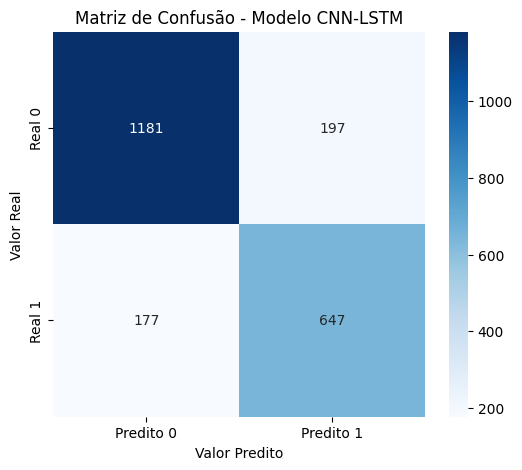


Gerando Curva ROC e calculando AUC...


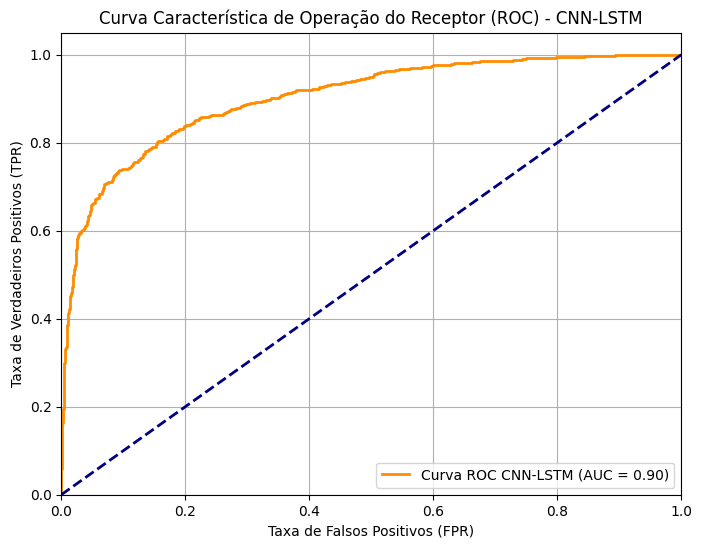


AUC (Area Under Curve) CNN-LSTM: 0.9028

Avaliação do modelo CNN-LSTM concluída.


In [9]:
# Célula 4: Avaliação do Modelo CNN-LSTM no Conjunto de Teste

print("--- Avaliando o Modelo CNN-LSTM no Conjunto de Teste ---")

# É esperado que model_cnn_lstm já contenha o melhor modelo carregado
# Se não, descomente a linha abaixo para carregar:
# model_cnn_lstm = keras.models.load_model(MODEL_SAVE_PATH_CNN_LSTM)

# 1. Fazer previsões no conjunto de teste
print("\nFazendo previsões no conjunto de teste...")
y_pred_proba_cnn_lstm = model_cnn_lstm.predict(X_test_scaled)
y_pred_cnn_lstm = (y_pred_proba_cnn_lstm > 0.5).astype(int).flatten() # Converter probabilidades para classes (0 ou 1)

# 2. Calcular métricas de avaliação
print("\nCalculando métricas de avaliação...")
accuracy_cnn_lstm = accuracy_score(y_test, y_pred_cnn_lstm)
precision_cnn_lstm = precision_score(y_test, y_pred_cnn_lstm, zero_division=0)
recall_cnn_lstm = recall_score(y_test, y_pred_cnn_lstm, zero_division=0)
f1_cnn_lstm = f1_score(y_test, y_pred_cnn_lstm, zero_division=0)

print(f"Acurácia no Teste: {accuracy_cnn_lstm:.4f}")
print(f"Precisão no Teste: {precision_cnn_lstm:.4f}")
print(f"Recall no Teste: {recall_cnn_lstm:.4f}")
print(f"F1-Score no Teste: {f1_cnn_lstm:.4f}")

# 3. Matriz de Confusão
print("\nGerando Matriz de Confusão...")
cm_cnn_lstm = confusion_matrix(y_test, y_pred_cnn_lstm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_cnn_lstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predito 0', 'Predito 1'],
            yticklabels=['Real 0', 'Real 1'])
plt.title('Matriz de Confusão - Modelo CNN-LSTM')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predito')
plt.show()

# 4. Curva ROC e AUC
print("\nGerando Curva ROC e calculando AUC...")
fpr_cnn_lstm, tpr_cnn_lstm, thresholds_cnn_lstm = roc_curve(y_test, y_pred_proba_cnn_lstm)
roc_auc_cnn_lstm = auc(fpr_cnn_lstm, tpr_cnn_lstm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn_lstm, tpr_cnn_lstm, color='darkorange', lw=2,
         label=f'Curva ROC CNN-LSTM (AUC = {roc_auc_cnn_lstm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva Característica de Operação do Receptor (ROC) - CNN-LSTM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"\nAUC (Area Under Curve) CNN-LSTM: {roc_auc_cnn_lstm:.4f}")
print("\nAvaliação do modelo CNN-LSTM concluída.")

In [10]:
# Célula 5: Salvar o Modelo CNN-LSTM Final e os Pré-processadores

print("--- Salvando o Modelo CNN-LSTM e os Pré-processadores ---")

# Assegure-se de que DATA_DIR e MODEL_SAVE_PATH_CNN_LSTM estão definidos como nas células anteriores
# Exemplo (reafirmando, caso esta célula seja executada isoladamente em outro momento):
# DATA_DIR = 'processed_data'
# MODEL_SAVE_PATH_CNN_LSTM = os.path.join(DATA_DIR, 'best_model_cnn_lstm.keras') # Definido na Célula 3

# 1. Salvar o Modelo CNN-LSTM
# O ModelCheckpoint na Célula 3 já deve ter salvo a melhor versão do modelo.
# A linha no final da Célula 3 também tentou carregar essa melhor versão na variável 'model_cnn_lstm'.
if 'model_cnn_lstm' in locals() or 'model_cnn_lstm' in globals():
    print(f"O melhor modelo CNN-LSTM (supostamente carregado em 'model_cnn_lstm') foi salvo durante o treino em: {MODEL_SAVE_PATH_CNN_LSTM}")
    # Se você quiser explicitamente salvar o objeto 'model_cnn_lstm' que está em memória:
    # model_cnn_lstm.save(MODEL_SAVE_PATH_CNN_LSTM)
    # print(f"Modelo CNN-LSTM (da variável 'model_cnn_lstm') salvo/ressalvo em: {MODEL_SAVE_PATH_CNN_LSTM}")
else:
    print(f"Variável 'model_cnn_lstm' não encontrada. O modelo deveria ter sido salvo por ModelCheckpoint em: {MODEL_SAVE_PATH_CNN_LSTM}")
    print("Certifique-se de que a Célula 3 foi executada e o modelo foi treinado e salvo.")


# 2. Salvar o StandardScaler usado para as features
# 'scaler' foi definido e ajustado na Célula 2
SCALER_SAVE_PATH_CNN_LSTM = os.path.join(DATA_DIR, 'scaler_model_cnn_lstm.joblib')

try:
    if 'scaler' in locals() or 'scaler' in globals():
        dump(scaler, SCALER_SAVE_PATH_CNN_LSTM)
        print(f"StandardScaler salvo em: {SCALER_SAVE_PATH_CNN_LSTM}")
    else:
        print("Erro: Objeto 'scaler' não está definido. Certifique-se de que a Célula 2 (onde o scaler é ajustado) foi executada.")
except Exception as e:
    print(f"Erro ao salvar o StandardScaler: {e}")

# 3. Salvar o LabelEncoder (se usado)
# No seu código, os rótulos 'y' parecem já ser 0 e 1, então um LabelEncoder explícito pode não ter sido usado.
# Se você usou um LabelEncoder (por exemplo, se seus rótulos fossem strings), você o salvaria aqui.
# Exemplo:
# LABEL_ENCODER_SAVE_PATH_CNN_LSTM = os.path.join(DATA_DIR, 'label_encoder_model_cnn_lstm.joblib')
# try:
#     if 'le' in locals() or 'le' in globals(): # Supondo que seu LabelEncoder se chame 'le'
#         dump(le, LABEL_ENCODER_SAVE_PATH_CNN_LSTM)
#         print(f"LabelEncoder salvo em: {LABEL_ENCODER_SAVE_PATH_CNN_LSTM}")
#     else:
#         print("Info: Objeto 'le' (LabelEncoder) não definido. Pulando o salvamento do LabelEncoder.")
# except Exception as e:
#     print(f"Erro ao salvar o LabelEncoder: {e}")
print("Lembrete: Se os rótulos (y) já eram numéricos (0/1) e não foi usado um LabelEncoder, não é necessário salvar um.")

print("\nSalvamento do modelo CNN-LSTM e pré-processadores concluído.")
print(f"Verifique o diretório '{DATA_DIR}' pelos arquivos salvos.")

--- Salvando o Modelo CNN-LSTM e os Pré-processadores ---
O melhor modelo CNN-LSTM (supostamente carregado em 'model_cnn_lstm') foi salvo durante o treino em: processed_data/best_model_cnn_lstm.keras
StandardScaler salvo em: processed_data/scaler_model_cnn_lstm.joblib
Lembrete: Se os rótulos (y) já eram numéricos (0/1) e não foi usado um LabelEncoder, não é necessário salvar um.

Salvamento do modelo CNN-LSTM e pré-processadores concluído.
Verifique o diretório 'processed_data' pelos arquivos salvos.


In [11]:
! pip install opencv-python mediapipe numpy tensorflow joblib

In [3]:
# Célula 6: Teste do Modelo CNN-LSTM com Câmera em Tempo Real

import cv2
import numpy as np
import mediapipe as mp
from tensorflow import keras
from joblib import load
import os
from collections import deque
import math # Para a função de distância

print("--- Testando o Modelo CNN-LSTM com Câmera ---")

# --- 0. Constantes e Caminhos (ajuste conforme necessário) ---
DATA_DIR = 'processed_data'
MODEL_FILE = 'best_model_cnn_lstm.keras'
SCALER_FILE = 'scaler_model_cnn_lstm.joblib'

MODEL_PATH = os.path.join(DATA_DIR, MODEL_FILE)
SCALER_PATH = os.path.join(DATA_DIR, SCALER_FILE)

# Tentar carregar o modelo e o scaler
try:
    model_cnn_lstm = keras.models.load_model(MODEL_PATH)
    print(f"Modelo CNN-LSTM carregado de: {MODEL_PATH}")
except Exception as e:
    print(f"Erro ao carregar o modelo: {e}")
    print("Certifique-se de que o caminho e o nome do arquivo do modelo estão corretos e a Célula 3/5 foi executada.")
    exit()

try:
    scaler = load(SCALER_PATH)
    print(f"StandardScaler carregado de: {SCALER_PATH}")
except Exception as e:
    print(f"Erro ao carregar o scaler: {e}")
    print("Certifique-se de que o caminho e o nome do arquivo do scaler estão corretos e a Célula 5 foi executada.")
    exit()

# --- 1. Obter Parâmetros do Modelo Carregado ---
try:
    _, TIMESTEPS, NUM_FEATURES_MODEL = model_cnn_lstm.input_shape # [cite: 27]
    print(f"Configuração do modelo: TIMESTEPS={TIMESTEPS}, NUM_FEATURES_MODEL={NUM_FEATURES_MODEL}")
    if NUM_FEATURES_MODEL != 2:
        print(f"AVISO CRÍTICO: O modelo espera {NUM_FEATURES_MODEL} características, mas esta célula está configurada para extrair 2 (EAR e MAR).")
        print("VOCÊ PRECISA AJUSTAR 'extract_features_from_face_metrics' PARA SEU MODELO se não forem EAR e MAR, ou se o número de features for diferente de 2.")
        # Considerar sair se NUM_FEATURES_MODEL não for o esperado para EAR e MAR
        # exit()
except Exception as e:
    print(f"Erro ao obter input_shape do modelo: {e}")
    print("Não foi possível determinar TIMESTEPS e NUM_FEATURES_MODEL a partir do modelo.")
    exit()

# --- 2. Configuração do MediaPipe Face Mesh ---
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils
# drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1) # Não usado diretamente abaixo

# --- 3. Funções Auxiliares para Cálculo de Métricas ---

def calculate_distance(point1, point2):
    """Calcula a distância euclidiana entre dois pontos 3D (landmarks)."""
    return math.sqrt((point1.x - point2.x)**2 + (point1.y - point2.y)**2 + (point1.z - point2.z)**2)

def calculate_ear(eye_landmarks, all_landmarks):
    """
    Calcula o Eye Aspect Ratio (EAR) para um olho.
    A fórmula é (dist(P2,P6) + dist(P3,P5)) / (2 * dist(P1,P4)).
    Os índices dos landmarks são baseados na documentação do MediaPipe Face Mesh.
    """
    try:
        # Pontos verticais
        p2 = all_landmarks[eye_landmarks[0]] # Ex: 160 (topo pálpebra)
        p6 = all_landmarks[eye_landmarks[1]] # Ex: 144 (base pálpebra)
        p3 = all_landmarks[eye_landmarks[2]] # Ex: 158 (topo pálpebra)
        p5 = all_landmarks[eye_landmarks[3]] # Ex: 153 (base pálpebra)
        # Pontos horizontais
        p1 = all_landmarks[eye_landmarks[4]] # Ex: 33 (canto externo)
        p4 = all_landmarks[eye_landmarks[5]] # Ex: 133 (canto interno)

        vertical_dist1 = calculate_distance(p2, p6)
        vertical_dist2 = calculate_distance(p3, p5)
        horizontal_dist = calculate_distance(p1, p4)

        if horizontal_dist == 0:
            return 0.0
        ear = (vertical_dist1 + vertical_dist2) / (2.0 * horizontal_dist)
        return ear
    except IndexError:
        print("Erro de índice ao acessar landmarks do olho para EAR.")
        return 0.0 # Ou algum valor de erro

def calculate_mar(mouth_landmarks, all_landmarks):
    """
    Calcula o Mouth Aspect Ratio (MAR).
    A fórmula é dist(P_topo, P_base) / dist(P_esquerda, P_direita).
    """
    try:
        p_topo = all_landmarks[mouth_landmarks[0]]  # Ex: 13 (centro lábio superior)
        p_base = all_landmarks[mouth_landmarks[1]]  # Ex: 14 (centro lábio inferior)
        p_esquerda = all_landmarks[mouth_landmarks[2]] # Ex: 61 (canto esquerdo boca)
        p_direita = all_landmarks[mouth_landmarks[3]] # Ex: 291 (canto direito boca)

        vertical_dist = calculate_distance(p_topo, p_base)
        horizontal_dist = calculate_distance(p_esquerda, p_direita)

        if horizontal_dist == 0:
            return 0.0
        mar = vertical_dist / horizontal_dist
        return mar
    except IndexError:
        print("Erro de índice ao acessar landmarks da boca para MAR.")
        return 0.0 # Ou algum valor de erro

# Índices dos landmarks do MediaPipe para olhos e boca
# Estes são exemplos e podem precisar de ajuste fino dependendo da precisão desejada
# e se `refine_landmarks` afeta a topologia principal para estes cálculos.
# Verifique a documentação do MediaPipe para os landmarks exatos.
# Para EAR (6 pontos por olho): P1, P2, P3, P4, P5, P6
# Olho direito: P2(160),P6(144), P3(158),P5(153), P1(33),P4(133) -> índices para lista [160,144,158,153,33,133]
# Olho esquerdo: P2(387),P6(373), P3(385),P5(380), P1(263),P4(362) -> índices para lista [387,373,385,380,263,362]
# (Ordem na lista para calculate_ear: [idx_p2, idx_p6, idx_p3, idx_p5, idx_p1, idx_p4])
RIGHT_EYE_LANDMARK_INDICES = [160, 144, 158, 153, 33, 133]
LEFT_EYE_LANDMARK_INDICES = [387, 373, 385, 380, 263, 362]
# Para MAR: P_topo, P_base, P_esquerda, P_direita
MOUTH_LANDMARK_INDICES = [13, 14, 61, 291]


def extract_features_from_face_metrics(face_landmarks_object_list):
    """
    Extrai EAR e MAR a partir dos landmarks faciais.
    Retorna um array NumPy com [ear_medio, mar].
    """
    features = np.zeros(NUM_FEATURES_MODEL, dtype=np.float32) # Espera 2 features

    if face_landmarks_object_list: # Lista de objetos de landmarks faciais detectados
        # Assumindo que estamos processando apenas o primeiro rosto detectado
        all_landmarks = face_landmarks_object_list[0].landmark

        # Calcular EAR para ambos os olhos e tirar a média
        ear_right = calculate_ear(RIGHT_EYE_LANDMARK_INDICES, all_landmarks)
        ear_left = calculate_ear(LEFT_EYE_LANDMARK_INDICES, all_landmarks)
        average_ear = (ear_right + ear_left) / 2.0

        # Calcular MAR
        mar = calculate_mar(MOUTH_LANDMARK_INDICES, all_landmarks)

        if NUM_FEATURES_MODEL == 2:
            features[0] = average_ear
            features[1] = mar
        else:
            # Se o modelo não espera 2 features, esta lógica precisa ser adaptada.
            # Por enquanto, apenas preenche com o que temos se for o caso,
            # mas o ideal é que NUM_FEATURES_MODEL seja 2 para esta implementação.
            print(f"Aviso: extract_features_from_face_metrics está gerando EAR e MAR, mas NUM_FEATURES_MODEL é {NUM_FEATURES_MODEL}")
            # Preencher como puder, ou retornar erro.
            if NUM_FEATURES_MODEL > 0: features[0] = average_ear
            if NUM_FEATURES_MODEL > 1: features[1] = mar
            # Outras features seriam zero.

    # Se nenhuma face for detectada, features já é um array de zeros.
    return features


# --- 4. Loop Principal da Câmera ---
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Erro: Não foi possível abrir a câmera.")
    exit()

sequence_buffer = deque(maxlen=TIMESTEPS)
prediction_text = "Aguardando dados..."
prediction_color = (0, 255, 255) # Amarelo

print("\nIniciando captura da câmera. Pressione 'q' para sair.")
print(f"O modelo espera {TIMESTEPS} amostras de tempo (frames) com {NUM_FEATURES_MODEL} características cada.")
if NUM_FEATURES_MODEL == 2:
    print("As características extraídas serão: [EAR médio, MAR].")
else:
    print(f"AVISO: As características extraídas serão EAR e MAR, mas o modelo espera {NUM_FEATURES_MODEL}. ISTO PROVAVELMENTE CAUSARÁ ERROS.")


while cap.isOpened():
    success, image = cap.read()
    if not success:
        print("Ignorando frame vazio da câmera.")
        continue

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_rgb.flags.writeable = False
    results = face_mesh.process(image_rgb)
    image_rgb.flags.writeable = True
    image_output = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

    current_features = None
    if results.multi_face_landmarks:
        # Desenhar landmarks (opcional)
        for face_landmarks in results.multi_face_landmarks:
            mp_drawing.draw_landmarks(
                image=image_output,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp.solutions.drawing_styles.get_default_face_mesh_tesselation_style())
            mp_drawing.draw_landmarks(
                image=image_output,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_CONTOURS,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp.solutions.drawing_styles.get_default_face_mesh_contours_style())
        
        # Extrair as métricas (EAR, MAR)
        current_features = extract_features_from_face_metrics(results.multi_face_landmarks)
    else:
        # Nenhum rosto detectado, preenche com zeros (ou a última característica válida, ou outra estratégia)
        current_features = np.zeros(NUM_FEATURES_MODEL, dtype=np.float32)
        prediction_text = "Nenhum rosto detectado"
        prediction_color = (0,0,255) # Vermelho

    if current_features is not None:
        sequence_buffer.append(current_features)

    if len(sequence_buffer) == TIMESTEPS:
        sequence_np = np.array(list(sequence_buffer)) # Shape: (TIMESTEPS, NUM_FEATURES_MODEL)

        # O scaler foi ajustado em dados com shape (num_samples * timesteps, num_features)
        sequence_reshaped_for_scaler = sequence_np.reshape(-1, NUM_FEATURES_MODEL)
        
        try:
            if sequence_reshaped_for_scaler.shape[1] != scaler.n_features_in_:
                print(f"Erro crítico de dimensionalidade antes do scaler: Features extraídas ({sequence_reshaped_for_scaler.shape[1]}) != Features esperadas pelo scaler ({scaler.n_features_in_}).")
                print("Verifique NUM_FEATURES_MODEL e a lógica de extract_features_from_face_metrics.")
                prediction_text = "Erro Dim Scaler!"
                prediction_color = (0,0,255) # Vermelho
                sequence_scaled_reshaped = np.zeros_like(sequence_reshaped_for_scaler) # Para evitar crash, mas predição inválida
            else:
                sequence_scaled_reshaped = scaler.transform(sequence_reshaped_for_scaler)
                prediction_color = (0, 255, 255) # Reset color if scaling was ok previously but now an error
        
        except ValueError as ve:
            print(f"Erro ao aplicar o scaler: {ve}")
            print(f"Scaler esperava {scaler.n_features_in_} features, obteve {sequence_reshaped_for_scaler.shape[1]}.")
            prediction_text = "Erro no Scaler!"
            prediction_color = (0,0,255) # Vermelho
            sequence_scaled_reshaped = np.zeros_like(sequence_reshaped_for_scaler) # Para evitar crash
        
        sequence_scaled = sequence_scaled_reshaped.reshape(1, TIMESTEPS, NUM_FEATURES_MODEL)

        if prediction_text not in ["Erro Dim Scaler!", "Erro no Scaler!", "Nenhum rosto detectado"]: # Só prever se não houve erro anterior grave
            prediction_proba = model_cnn_lstm.predict(sequence_scaled)[0]
            prediction_class = (prediction_proba > 0.5).astype(int)[0]
            prediction_text = f"Classe: {prediction_class} (Prob: {prediction_proba[0]:.2f})"
            # Verde para classe 1 (Fadigado, por exemplo), Azul claro para 0 (Normal)
            prediction_color = (0, 255, 0) if prediction_class == 1 else (255, 100, 100)
        
    cv2.putText(image_output, prediction_text, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, prediction_color, 2)
    cv2.putText(image_output, f"Buffer: {len(sequence_buffer)}/{TIMESTEPS}", (10, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200, 200, 0), 1)

    cv2.imshow('Teste Modelo CNN-LSTM com Camera', image_output)

    if cv2.waitKey(5) & 0xFF == ord('q'):
        break

# --- 5. Limpeza ---
cap.release()
cv2.destroyAllWindows()
if 'face_mesh' in locals() and face_mesh is not None: # Adicionado para segurança
    face_mesh.close()
print("Teste finalizado.")

--- Testando o Modelo CNN-LSTM com Câmera ---
Modelo CNN-LSTM carregado de: processed_data/best_model_cnn_lstm.keras
StandardScaler carregado de: processed_data/scaler_model_cnn_lstm.joblib
Configuração do modelo: TIMESTEPS=90, NUM_FEATURES_MODEL=2

Iniciando captura da câmera. Pressione 'q' para sair.
O modelo espera 90 amostras de tempo (frames) com 2 características cada.
As características extraídas serão: [EAR médio, MAR].


I0000 00:00:1748275096.870576   23109 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1748275096.896423   56734 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 575.51.03), renderer: NVIDIA GeForce RTX 4060 Ti/PCIe/SSE2
W0000 00:00:1748275096.899849   56713 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1748275096.907590   56715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━